# Load the Data with Hidden States

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from Get_Go_Emo import get_go
from Get_Isear import get_isr

num_samples = 1000

In [2]:
# Modified data loading and preprocessing
def load_and_preprocess_hidden_states(path):
    """Load hidden states from JSON and restructure into dict-of-layers format"""
    df = pd.read_json(path, orient='records')
    
    # Convert column-wise layers to row-wise dictionaries
    if 'hidden_states' not in df.columns:
        # Assuming columns are named layer_0, layer_1, etc.
        layers = [col for col in df.columns if col.startswith('layer_')]
        df['hidden_states'] = df[layers].apply(
            lambda row: {layer: row[layer] for layer in layers},
            axis=1
        )
        df = df[['hidden_states']]  # Keep only the restructured column
    
    return df

# Load datasets with restructuring
bert_goEmo_hidden = load_and_preprocess_hidden_states('hidden_states/bert-base-uncased_goEmo.json')
bert_isear_hidden = load_and_preprocess_hidden_states('hidden_states/bert-base-uncased_isear.json')
gpt2_goEmo_hidden = load_and_preprocess_hidden_states('hidden_states/gpt2_goEmo.json')
gpt2_isear_hidden = load_and_preprocess_hidden_states('hidden_states/gpt2_isear.json')

# The rest of your original code can remain the same...

In [3]:

def train_probes_from_hidden_states(hidden_states_df, labels, model_name, dataset_name, test_size=0.2, random_state=42):
    """
    Train logistic regression probes for each layer using pre-loaded hidden states.
    
    Args:
        hidden_states_df: DataFrame containing hidden states
        labels: Array of labels corresponding to hidden states
        model_name: Name of the model for reporting
        dataset_name: Name of the dataset for reporting
        test_size: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary of layer accuracies
    """
    print(f"\nTraining probes for {model_name} on {dataset_name}...")
    
    if hidden_states_df is None or len(hidden_states_df) == 0:
        print("No hidden states found, skipping...")
        return {}
    
    # Get the hidden states from the dataframe
    try:
        # Check the structure of hidden_states_df
        if 'hidden_states' in hidden_states_df.columns:
            hidden_states = hidden_states_df['hidden_states'].tolist()
        else:
            # If there's only one column, use that
            hidden_states = hidden_states_df[hidden_states_df.columns[0]].tolist()
    except Exception as e:
        print(f"Error accessing hidden states: {e}")
        # Try to examine the dataframe structure
        print(f"Dataframe columns: {hidden_states_df.columns}")
        return {}
    
    # Check if the first hidden state is a dictionary of layers
    if not hidden_states or not isinstance(hidden_states[0], dict):
        print(f"Invalid hidden states format for {model_name}. Expected dict of layers.")
        return {}
    
    # Extract layers from the first entry
    layers = list(hidden_states[0].keys())
    layer_accuracies = {}
    
    # Check if we can use stratified split
    y = np.array(labels)
    min_class_count = min(Counter(y).values()) if len(Counter(y)) > 0 else 0
    stratify = y if min_class_count >= 2 else None
    if stratify is None:
        print(f"Warning: Some classes have only 1 sample, not using stratified split")
    
    for layer in layers:
        try:
            # Extract embeddings for this layer
            X = np.array([state[layer] for state in hidden_states])
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, 
                test_size=test_size, 
                random_state=random_state, 
                stratify=stratify
            )
            
            # Train classifier with standardization
            clf = make_pipeline(
                StandardScaler(),
                LogisticRegression(solver='saga', max_iter=2000, random_state=random_state)
            )
            clf.fit(X_train, y_train)
            
            # Evaluate
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            layer_accuracies[layer] = acc
            print(f"  Layer {layer}: Accuracy = {acc:.4f}")
            
        except Exception as e:
            print(f"Error processing layer {layer}: {e}")
            layer_accuracies[layer] = 0
    
    return layer_accuracies

def plot_accuracies(accuracies, model_name, dataset_name):
    """Plot accuracy vs. layer number."""
    if not accuracies:
        print(f"No accuracies to plot for {model_name} on {dataset_name}")
        return
    
    try:
        layers = sorted(accuracies.keys(), key=lambda x: int(x.split('_')[1]))
        layer_nums = [int(layer.split('_')[1]) for layer in layers]
        acc_values = [accuracies[layer] for layer in layers]
        
        plt.figure(figsize=(10, 6))
        plt.plot(layer_nums, acc_values, marker='o', linestyle='-')
        plt.title(f"Layer-wise Accuracy for {model_name} on {dataset_name}")
        plt.xlabel("Layer Number")
        plt.ylabel("Accuracy")
        plt.xticks(layer_nums)
        plt.grid(True)
        plt.savefig(f"{model_name}_{dataset_name}_accuracy.png")
        plt.show()
    except Exception as e:
        print(f"Error plotting for {model_name} on {dataset_name}: {e}")

def plot_all_model_layer_metrics(accuracies_dict, metric_name='accuracy'):
    """
    Plot horizontal bar charts where:
    - Y-axis: Dataset name + model + layer
    - X-axis: Metric value (accuracy by default)
    
    Args:
        accuracies_dict: Nested dictionary in format {model_dataset: {layer: metric_value}}
        metric_name: Name of the metric to display in title
    """
    plt.figure(figsize=(12, 10))
    
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    # Flatten the nested dictionary
    for model_dataset, layers in accuracies_dict.items():
        for layer, value in layers.items():
            plot_data.append(value)
            labels.append(f"{model_dataset} | {layer}")
    
    # Sort values and labels together
    sorted_indices = np.argsort(plot_data)
    sorted_values = np.array(plot_data)[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]
    
    # Create horizontal bars
    y_pos = np.arange(len(sorted_labels))
    bars = plt.barh(y_pos, sorted_values, alpha=0.6)
    
    # Add value text
    for i, value in enumerate(sorted_values):
        plt.text(value + 0.01, i, f"{value:.3f}", va='center')
    
    # Formatting
    plt.title(f"Model Layer Performance: {metric_name.capitalize()}")
    plt.xlabel(metric_name.capitalize())
    plt.ylabel("Model | Dataset | Layer")
    plt.yticks(y_pos, sorted_labels)
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{metric_name}_comparison.png")
    plt.show()




def plot_model_layer_metrics(accuracies_dict, metric_name='accuracy'):
    """
    Plot separate line charts for each model-dataset combination showing layer-wise performance
    
    Args:
        accuracies_dict: Nested dictionary in format {model_dataset: {layer: metric_value}}
        metric_name: Name of the metric to display
    """
    # Create a figure for each model-dataset combination
    for model_dataset, layer_accuracies in accuracies_dict.items():
        # Split model and dataset names
        try:
            model_name, dataset_name = model_dataset.split(" | ")
        except ValueError:
            model_name = model_dataset
            dataset_name = "Unknown"
        
        # Prepare data for plotting
        layers = sorted(layer_accuracies.keys(), key=lambda x: int(x.split('_')[1]))
        layer_numbers = [int(layer.split('_')[1]) for layer in layers]
        acc_values = [layer_accuracies[layer] for layer in layers]
        
        # Create plot
        plt.figure(figsize=(10, 6))
        
        # Line plot with markers
        plt.plot(layer_numbers, acc_values, 
                 marker='o', linestyle='-', 
                 color='tab:blue', linewidth=2)
        
        # Formatting
        plt.title(f"Layer-wise {metric_name.capitalize()}: {model_name} on {dataset_name}")
        plt.xlabel("Layer Number")
        plt.ylabel(metric_name.capitalize())
        plt.xticks(layer_numbers)
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)  # Assuming accuracy is between 0-1
        
        # Add value labels
        for x, y in zip(layer_numbers, acc_values):
            plt.text(x, y+0.02, f"{y:.3f}",
                    ha='center', va='bottom',
                    fontsize=8)
        
        # Save and show
        plt.tight_layout()
        plt.savefig(f"{metric_name}_{model_name}_{dataset_name}.png")
        plt.show()

In [4]:
goEmo = get_go()
isear = get_isr()

In [5]:
model_datasets = {
    'bert-base-uncased': {
        'GoEmo': {
            'data': goEmo[:num_samples],
            'hidden_states': bert_goEmo_hidden
        },
        'ISEAR': {
            'data': isear[:num_samples],
            'hidden_states': bert_isear_hidden
        }
    },
    'gpt2': {
        'GoEmo': {
            'data': goEmo[:num_samples],
            'hidden_states': gpt2_goEmo_hidden
        },
        'ISEAR': {
            'data': isear[:num_samples],
            'hidden_states': gpt2_isear_hidden
        }
    }
}



=== Processing bert-base-uncased ===

Training probes for bert-base-uncased on GoEmo...
  Layer layer_0: Accuracy = 0.2900
  Layer layer_1: Accuracy = 0.2500
  Layer layer_2: Accuracy = 0.2800
  Layer layer_3: Accuracy = 0.2800
  Layer layer_4: Accuracy = 0.2850
  Layer layer_5: Accuracy = 0.2950
  Layer layer_6: Accuracy = 0.2900
  Layer layer_7: Accuracy = 0.3000
  Layer layer_8: Accuracy = 0.2950
  Layer layer_9: Accuracy = 0.3150
  Layer layer_10: Accuracy = 0.3000


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_11: Accuracy = 0.3150
  Layer layer_12: Accuracy = 0.2950


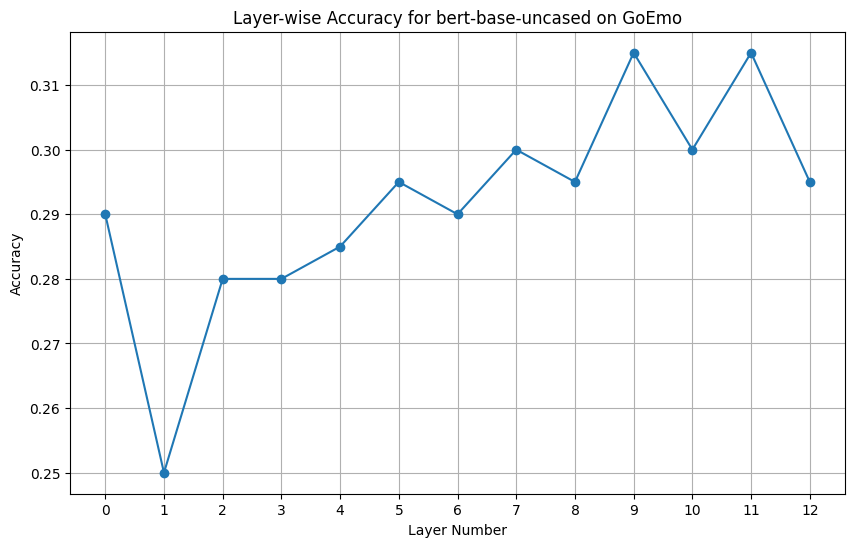


Training probes for bert-base-uncased on ISEAR...


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_0: Accuracy = 0.1400
  Layer layer_1: Accuracy = 0.3750
  Layer layer_2: Accuracy = 0.3900
  Layer layer_3: Accuracy = 0.3650
  Layer layer_4: Accuracy = 0.4550
  Layer layer_5: Accuracy = 0.4050
  Layer layer_6: Accuracy = 0.3900
  Layer layer_7: Accuracy = 0.4050
  Layer layer_8: Accuracy = 0.4100
  Layer layer_9: Accuracy = 0.4500
  Layer layer_10: Accuracy = 0.4050
  Layer layer_11: Accuracy = 0.4450
  Layer layer_12: Accuracy = 0.4600


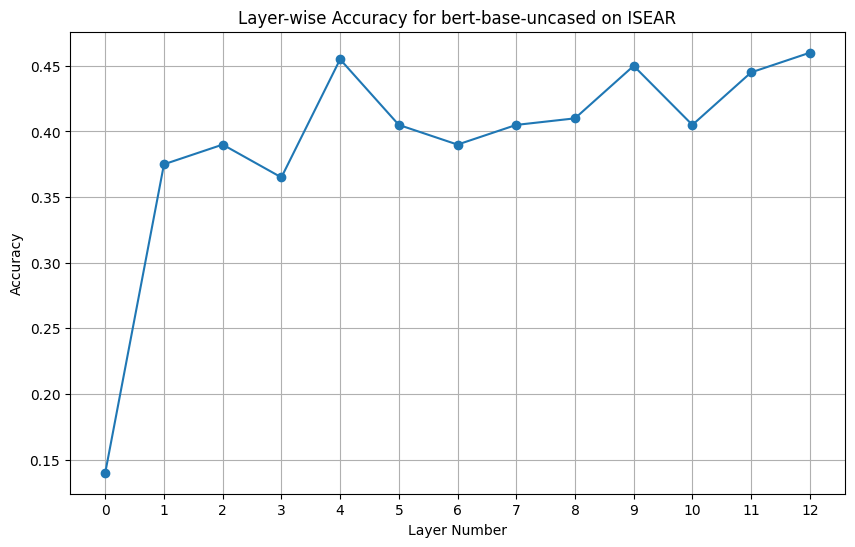


=== Processing gpt2 ===

Training probes for gpt2 on GoEmo...


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_0: Accuracy = 0.2800


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_1: Accuracy = 0.2600


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_2: Accuracy = 0.2600


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_3: Accuracy = 0.2500


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_4: Accuracy = 0.2500


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_5: Accuracy = 0.2500


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_6: Accuracy = 0.2750


/Users/amirali/Desktop/Final-Year-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Layer layer_7: Accuracy = 0.2750


In [6]:
# Dictionary to store all results
all_results = {}

# Train probes for each model and dataset
for model_name, datasets in model_datasets.items():
    print(f"\n=== Processing {model_name} ===")
    
    for dataset_name, data_dict in datasets.items():
        # Get dataset and hidden states
        dataset = data_dict['data']
        hidden_states = data_dict['hidden_states']
        
        # Train probes on current dataset
        try:
            labels = dataset['labels'].values  # Adjust if your label column has a different name
            accuracies = train_probes_from_hidden_states(
                hidden_states, labels, model_name, dataset_name
            )
            all_results[f"{model_name} | {dataset_name}"] = accuracies
            
            # Plot results
            if accuracies:
                plot_accuracies(accuracies, model_name, dataset_name)
        except Exception as e:
            print(f"Error in probe training for {model_name} on {dataset_name}: {e}")
            # Print more debug info
            print(f"Dataset shape: {dataset.shape if dataset is not None else 'None'}")
            print(f"Hidden states shape: {hidden_states.shape if hidden_states is not None else 'None'}")
            continue

# Plot comparative metrics for all models and datasets
print("\nGenerating comparison plot...")
plot_all_model_layer_metrics(all_results, metric_name='accuracy')
plot_model_layer_metrics(all_results, metric_name='accuracy')

print("\nAnalysis complete! Results saved as PNG files.")